# Tutorial 06

## template fitting pipeline pre-process

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
NSAMP = 30
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')
ell = np.arange(cmb_cl.shape[1])
mapcmb = np.empty((NSAMP+1,3,map30f.shape[1]),dtype=np.float32)
for i in range(NSAMP+1):
    mapcmb[i] = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
#vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
#vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap95 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap150.shape[1]))*np.sqrt(vmap150)
#nmap30 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap30.shape[1]))*np.sqrt(vmap30)
#nmap353 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap353.shape[1]))*np.sqrt(vmap353)

map95 = hp.smoothing(mapcmb[0]+map95f,fwhm=fwhm[1],verbose=0)+nmap95[0]
map150 = hp.smoothing(mapcmb[0]+map150f,fwhm=fwhm[2],verbose=0)+nmap150[0]
#map30 = hp.smoothing(mapcmb+map30f,fwhm=fwhm[0],verbose=0)+nmap30[0]
#map353 = hp.smoothing(mapcmb+map353f,fwhm=fwhm[3],verbose=0)+nmap353[0]

fullmap = dict()
fullmap[95] = map95
fullmap[150] = map150

fullnoise = dict()
fullnoise[95] = nmap95[1:]
fullnoise[150] = nmap150[1:]

fullfiducial = dict()
fullfiducial[95] = mapcmb[1:]
fullfiducial[150] = mapcmb[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

tmpmap = dict()
tmpmap[30] = map30f
tmpmap[353] = map353f

tmpbeam = dict()
tmpbeam[30] = fwhm[0]
tmpbeam[353] = fwhm[3]

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### simple likelihood pre-process

- T mode

CPU times: user 1min 18s, sys: 730 ms, total: 1min 18s
Wall time: 10.1 s


<AxesSubplot:>

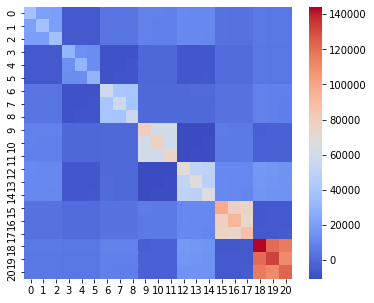

In [2]:
%%time

TARGET = 'T'
pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_fwhms=tmpbeam,targets=TARGET)
rslt_t = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(rslt_t[3],cmap='coolwarm',annot=False,ax=ax)

- E mode

CPU times: user 31min 42s, sys: 3.7 s, total: 31min 46s
Wall time: 3min 58s


<AxesSubplot:>

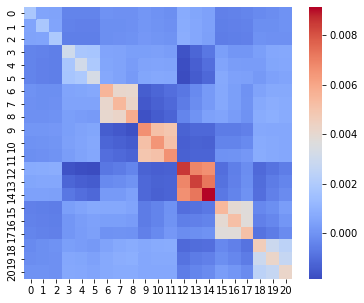

In [3]:
%%time

pipeline.targets = 'E'
rslt_e = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(rslt_e[3],cmap='coolwarm',annot=False,ax=ax)

- B mode

CPU times: user 32min 26s, sys: 4.15 s, total: 32min 30s
Wall time: 4min 4s


<AxesSubplot:>

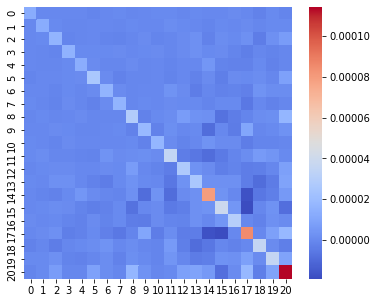

In [4]:
%%time

pipeline.targets = 'B'
rslt_b = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(rslt_b[3],cmap='coolwarm',annot=False,ax=ax)

- E & B modes

CPU times: user 50min 37s, sys: 6.71 s, total: 50min 44s
Wall time: 6min 22s


<AxesSubplot:>

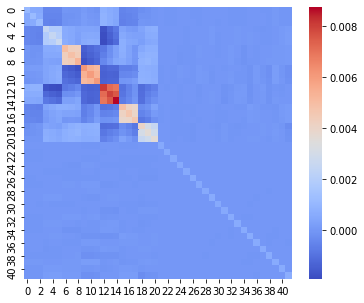

In [5]:
%%time

pipeline.targets = 'EB'
rslt_b = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(rslt_b[3],cmap='coolwarm',annot=False,ax=ax)

#### window function matrix (top-hat according to NaMaster)

<AxesSubplot:>

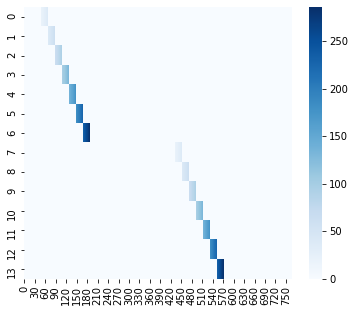

In [6]:
from afra.tools.ps_estimator import pstimator
from afra.tools.aux import bp_window

est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,targets='EB')
window = bp_window(est)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(window,cmap='Blues',annot=False,ax=ax)

end